In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from functools import reduce
from pyspark.sql.functions import isnan, when, count, col
import matplotlib.pyplot as plt

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import when,col
from pyspark.sql import functions as F

import warnings
warnings.filterwarnings("ignore")

In [2]:
spark = SparkSession.builder.appName("SPARK").config("spark.driver.memory", "12g").getOrCreate()
spark

22/12/29 18:07:40 WARN Utils: Your hostname, Kate resolves to a loopback address: 127.0.1.1; using 192.168.88.157 instead (on interface wlo1)
22/12/29 18:07:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/29 18:07:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Load csv to Spark DataFrame
TRAFFIC_DATA = "f_Hour_InterfaceMetrics_1.csv"

traffic_df = spark.read.options(header='True',inferSchema='True',handleInvalid='skip') \
                    .csv(path=TRAFFIC_DATA)

# Display the schema of DataFrame
traffic_df.printSchema()

root
 |-- Hour (of Day): timestamp (nullable = true)
 |-- Hour: string (nullable = true)
 |-- Interface Name: string (nullable = true)
 |-- Interface Alias: string (nullable = true)
 |-- Interface Descr: string (nullable = true)
 |-- Interface Physical Address: string (nullable = true)
 |-- Interface UUID: string (nullable = true)
 |-- Node Name: string (nullable = true)
 |-- Node Short Name: string (nullable = true)
 |-- Node Location: string (nullable = true)
 |-- Node Family: string (nullable = true)
 |-- Node Vendor: string (nullable = true)
 |-- Node UUID: string (nullable = true)
 |-- Packet Size - Bytes (avg): double (nullable = true)
 |-- Unicast - Packets In (sum): long (nullable = true)
 |-- Utilization (avg): double (nullable = true)
 |-- Unicast - Packets Out (sum): string (nullable = true)
 |-- Reboot (avg): double (nullable = true)
 |-- Errors - Packets In (sum): integer (nullable = true)
 |-- SNMP Response Time (msecs) (avg): double (nullable = true)
 |-- LAN FCS Error C

In [4]:
# https://www.linkedin.com/pulse/how-deal-white-spaces-column-names-your-raw-dataset-using-anirban-som/
from functools import reduce
current_columns = traffic_df.columns

new_columns = list(map(lambda item : item.replace(" ","_").replace(".","_").upper().strip(),current_columns)) 

final_df = reduce(lambda data, idx: data.withColumnRenamed(current_columns[idx], new_columns[idx]), range(len(current_columns)), traffic_df)

final_df.printSchema()

root
 |-- HOUR_(OF_DAY): timestamp (nullable = true)
 |-- HOUR: string (nullable = true)
 |-- INTERFACE_NAME: string (nullable = true)
 |-- INTERFACE_ALIAS: string (nullable = true)
 |-- INTERFACE_DESCR: string (nullable = true)
 |-- INTERFACE_PHYSICAL_ADDRESS: string (nullable = true)
 |-- INTERFACE_UUID: string (nullable = true)
 |-- NODE_NAME: string (nullable = true)
 |-- NODE_SHORT_NAME: string (nullable = true)
 |-- NODE_LOCATION: string (nullable = true)
 |-- NODE_FAMILY: string (nullable = true)
 |-- NODE_VENDOR: string (nullable = true)
 |-- NODE_UUID: string (nullable = true)
 |-- PACKET_SIZE_-_BYTES_(AVG): double (nullable = true)
 |-- UNICAST_-_PACKETS_IN_(SUM): long (nullable = true)
 |-- UTILIZATION_(AVG): double (nullable = true)
 |-- UNICAST_-_PACKETS_OUT_(SUM): string (nullable = true)
 |-- REBOOT_(AVG): double (nullable = true)
 |-- ERRORS_-_PACKETS_IN_(SUM): integer (nullable = true)
 |-- SNMP_RESPONSE_TIME_(MSECS)_(AVG): double (nullable = true)
 |-- LAN_FCS_ERROR_C

In [5]:
# Display newly modified columns
final_df.columns

['HOUR_(OF_DAY)',
 'HOUR',
 'INTERFACE_NAME',
 'INTERFACE_ALIAS',
 'INTERFACE_DESCR',
 'INTERFACE_PHYSICAL_ADDRESS',
 'INTERFACE_UUID',
 'NODE_NAME',
 'NODE_SHORT_NAME',
 'NODE_LOCATION',
 'NODE_FAMILY',
 'NODE_VENDOR',
 'NODE_UUID',
 'PACKET_SIZE_-_BYTES_(AVG)',
 'UNICAST_-_PACKETS_IN_(SUM)',
 'UTILIZATION_(AVG)',
 'UNICAST_-_PACKETS_OUT_(SUM)',
 'REBOOT_(AVG)',
 'ERRORS_-_PACKETS_IN_(SUM)',
 'SNMP_RESPONSE_TIME_(MSECS)_(AVG)',
 'LAN_FCS_ERROR_COUNT_(SUM)',
 'DISCARDS_-_PACKETS_OUT_(SUM)',
 'BROADCAST_-_PACKETS_IN_(SUM)',
 'INVALID_DATA_(AVG)',
 'NONUNICAST_-_PACKETS_OUT_(SUM)',
 'LAN_FCS_ERROR_RATE_(AVG)',
 'ERRORS_-_PACKETS_OUT_(SUM)',
 'BROADCAST_-_PACKETS_OUT_(SUM)',
 'NONUNICAST_-_PACKETS_IN_(SUM)',
 'THROUGHPUT_(BPS)_(AVG)',
 'BROADCAST_-_PACKETS_(SUM)',
 'VOLUME_-_PACKETS_(SUM)',
 'ERRORS_-_PACKETS_(SUM)',
 'PACKET_SIZE_-_BYTES_OUT_(AVG)',
 'DISCARD_RATE_OUT_(AVG)',
 'LAN_COLLISION_RATE_(AVG)',
 'VOLUME_-_BYTES_(SUM)',
 'PACKET_SIZE_-_BYTES_IN_(AVG)',
 'DISCARDS_-_PACKETS_(SUM)

In [6]:
# Create a subtable by selecting some columns

sub_df = final_df.select('HOUR',
 'INTERFACE_DESCR',
 'NODE_LOCATION',
 'UTILIZATION_(AVG)',
 'REBOOT_(AVG)',
 'ERRORS_-_PACKETS_IN_(SUM)',
 'DISCARDS_-_PACKETS_OUT_(SUM)',
 'BROADCAST_-_PACKETS_IN_(SUM)',
 'INVALID_DATA_(AVG)',
 'NONUNICAST_-_PACKETS_OUT_(SUM)',
 'ERRORS_-_PACKETS_OUT_(SUM)',
 'BROADCAST_-_PACKETS_OUT_(SUM)',
 'NONUNICAST_-_PACKETS_IN_(SUM)',
 'THROUGHPUT_(BPS)_(AVG)',
 'BROADCAST_-_PACKETS_(SUM)',
 'ERRORS_-_PACKETS_(SUM)',
 'PACKET_SIZE_-_BYTES_OUT_(AVG)',
 'DISCARD_RATE_OUT_(AVG)',
 'PACKET_SIZE_-_BYTES_IN_(AVG)',
 'DISCARDS_-_PACKETS_(SUM)',
 'MULTICAST_-_PACKETS_IN_(SUM)',
 'NONUNICAST_-_PACKETS_(SUM)',
 'THROUGHPUT_OUT_(BPS)_(AVG)',
 'UTILIZATION_OUT_(AVG)',
 'UNRESPONSIVE_TARGET_(AVG)',
 'DISCARDS_-_PACKETS_IN_(SUM)',
 'AVAILABILITY_(AVG)',
 'UTILIZATION_IN_(MAX)')                      

sub_df.count()

541791

In [7]:
df= sub_df.na.fill(0)

In [8]:
data=df.filter(col("UTILIZATION_(AVG)")  < 1)

In [9]:
df=data.withColumn("UTILIZATION", F.when(col("UTILIZATION_(AVG)") >= 0.4, 1).otherwise(0))

In [10]:
# Check for any NaN values
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

22/12/29 18:07:52 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+---------------+-------------+-----------------+------------+-------------------------+----------------------------+----------------------------+------------------+------------------------------+--------------------------+-----------------------------+-----------------------------+----------------------+-------------------------+----------------------+-----------------------------+----------------------+----------------------------+------------------------+----------------------------+--------------------------+--------------------------+---------------------+-------------------------+---------------------------+------------------+--------------------+-----------+
|HOUR|INTERFACE_DESCR|NODE_LOCATION|UTILIZATION_(AVG)|REBOOT_(AVG)|ERRORS_-_PACKETS_IN_(SUM)|DISCARDS_-_PACKETS_OUT_(SUM)|BROADCAST_-_PACKETS_IN_(SUM)|INVALID_DATA_(AVG)|NONUNICAST_-_PACKETS_OUT_(SUM)|ERRORS_-_PACKETS_OUT_(SUM)|BROADCAST_-_PACKETS_OUT_(SUM)|NONUNICAST_-_PACKETS_IN_(SUM)|THROUGHPUT_(BPS)_(AVG)|BROADCAST_

In [11]:

numeric_features = [t[0] for t in df.dtypes if t[1] == 'int' or t[1] == 'double']
df.describe(numeric_features).toPandas().transpose()


,0,1,2,3,4
summary,count,mean,stddev,min,max
UTILIZATION_(AVG),541774,0.04083123408879186,0.056022005520429005,0.0,0.9632300138473511
REBOOT_(AVG),541774,3.898714636968358E-5,0.0031336195953286555,0.0,0.4166666567325592
ERRORS_-_PACKETS_IN_(SUM),541774,0.0,0.0,0,0
DISCARDS_-_PACKETS_OUT_(SUM),541774,3.483384215558517,558.8439479924775,0,134699
BROADCAST_-_PACKETS_IN_(SUM),541774,439.72573803837025,1423.5127463921324,0,198034
INVALID_DATA_(AVG),541774,0.173268443812839,0.3783569640537808,0.0,1.0
NONUNICAST_-_PACKETS_OUT_(SUM),541774,2835900.5085847606,8062661.390465902,0,111056024
ERRORS_-_PACKETS_OUT_(SUM),541774,0.0,0.0,0,0
BROADCAST_-_PACKETS_OUT_(SUM),541774,332.0902664210538,769.4588357531691,0,147910


In [12]:
df.groupby('UTILIZATION').count().toPandas()

,UTILIZATION,count
0,1,1489
1,0,540285


In [13]:
# графики корреляции
# numeric_data = df.select(numeric_features).toPandas()

# axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));

# # Rotate axis labels and remove axis ticks
# n = len(numeric_data.columns)
# for i in range(n):
#     v = axs[i, 0]
#     v.yaxis.label.set_rotation(0)
#     v.yaxis.label.set_ha('right')
#     v.set_yticks(())
#     h = axs[n-1, i]
#     h.xaxis.label.set_rotation(90)
#     h.set_xticks(())

In [14]:
df.printSchema()

root
 |-- HOUR: string (nullable = true)
 |-- INTERFACE_DESCR: string (nullable = true)
 |-- NODE_LOCATION: string (nullable = true)
 |-- UTILIZATION_(AVG): double (nullable = false)
 |-- REBOOT_(AVG): double (nullable = false)
 |-- ERRORS_-_PACKETS_IN_(SUM): integer (nullable = true)
 |-- DISCARDS_-_PACKETS_OUT_(SUM): integer (nullable = true)
 |-- BROADCAST_-_PACKETS_IN_(SUM): integer (nullable = true)
 |-- INVALID_DATA_(AVG): double (nullable = false)
 |-- NONUNICAST_-_PACKETS_OUT_(SUM): integer (nullable = true)
 |-- ERRORS_-_PACKETS_OUT_(SUM): integer (nullable = true)
 |-- BROADCAST_-_PACKETS_OUT_(SUM): integer (nullable = true)
 |-- NONUNICAST_-_PACKETS_IN_(SUM): integer (nullable = true)
 |-- THROUGHPUT_(BPS)_(AVG): double (nullable = false)
 |-- BROADCAST_-_PACKETS_(SUM): integer (nullable = true)
 |-- ERRORS_-_PACKETS_(SUM): integer (nullable = true)
 |-- PACKET_SIZE_-_BYTES_OUT_(AVG): double (nullable = false)
 |-- DISCARD_RATE_OUT_(AVG): double (nullable = false)
 |-- PACKE

In [15]:
df=df.select('HOUR',
 'INTERFACE_DESCR',
 'NODE_LOCATION',
 'REBOOT_(AVG)',
 'ERRORS_-_PACKETS_IN_(SUM)',
 'DISCARDS_-_PACKETS_OUT_(SUM)',
 'BROADCAST_-_PACKETS_IN_(SUM)',
 'INVALID_DATA_(AVG)',
 'NONUNICAST_-_PACKETS_OUT_(SUM)',
 'ERRORS_-_PACKETS_OUT_(SUM)',
 'BROADCAST_-_PACKETS_OUT_(SUM)',
 'NONUNICAST_-_PACKETS_IN_(SUM)',
 'THROUGHPUT_(BPS)_(AVG)',
 'BROADCAST_-_PACKETS_(SUM)',
 'ERRORS_-_PACKETS_(SUM)',
 'PACKET_SIZE_-_BYTES_OUT_(AVG)',
 'DISCARD_RATE_OUT_(AVG)',
 'PACKET_SIZE_-_BYTES_IN_(AVG)',
 'DISCARDS_-_PACKETS_(SUM)',
 'MULTICAST_-_PACKETS_IN_(SUM)',
 'NONUNICAST_-_PACKETS_(SUM)',
 'THROUGHPUT_OUT_(BPS)_(AVG)',
 'UTILIZATION_OUT_(AVG)',
 'UNRESPONSIVE_TARGET_(AVG)',
 'DISCARDS_-_PACKETS_IN_(SUM)',
 'AVAILABILITY_(AVG)',
 'UTILIZATION',
 'UTILIZATION_IN_(MAX)')
cols = df.columns
df.printSchema()

root
 |-- HOUR: string (nullable = true)
 |-- INTERFACE_DESCR: string (nullable = true)
 |-- NODE_LOCATION: string (nullable = true)
 |-- REBOOT_(AVG): double (nullable = false)
 |-- ERRORS_-_PACKETS_IN_(SUM): integer (nullable = true)
 |-- DISCARDS_-_PACKETS_OUT_(SUM): integer (nullable = true)
 |-- BROADCAST_-_PACKETS_IN_(SUM): integer (nullable = true)
 |-- INVALID_DATA_(AVG): double (nullable = false)
 |-- NONUNICAST_-_PACKETS_OUT_(SUM): integer (nullable = true)
 |-- ERRORS_-_PACKETS_OUT_(SUM): integer (nullable = true)
 |-- BROADCAST_-_PACKETS_OUT_(SUM): integer (nullable = true)
 |-- NONUNICAST_-_PACKETS_IN_(SUM): integer (nullable = true)
 |-- THROUGHPUT_(BPS)_(AVG): double (nullable = false)
 |-- BROADCAST_-_PACKETS_(SUM): integer (nullable = true)
 |-- ERRORS_-_PACKETS_(SUM): integer (nullable = true)
 |-- PACKET_SIZE_-_BYTES_OUT_(AVG): double (nullable = false)
 |-- DISCARD_RATE_OUT_(AVG): double (nullable = false)
 |-- PACKET_SIZE_-_BYTES_IN_(AVG): double (nullable = false)

In [16]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['HOUR', 'INTERFACE_DESCR', 'NODE_LOCATION']
#categoricalColumns = []
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'UTILIZATION', outputCol = 'label')
stages += [label_stringIdx]

numericCols = [
 'REBOOT_(AVG)',
 'ERRORS_-_PACKETS_IN_(SUM)',
 'DISCARDS_-_PACKETS_OUT_(SUM)',
 'BROADCAST_-_PACKETS_IN_(SUM)',
 'INVALID_DATA_(AVG)',
 'NONUNICAST_-_PACKETS_OUT_(SUM)',
 'ERRORS_-_PACKETS_OUT_(SUM)',
 'BROADCAST_-_PACKETS_OUT_(SUM)',
 'NONUNICAST_-_PACKETS_IN_(SUM)',
 'THROUGHPUT_(BPS)_(AVG)',
 'BROADCAST_-_PACKETS_(SUM)',
 'ERRORS_-_PACKETS_(SUM)',
 'PACKET_SIZE_-_BYTES_OUT_(AVG)',
 'DISCARD_RATE_OUT_(AVG)',
 'PACKET_SIZE_-_BYTES_IN_(AVG)',
 'DISCARDS_-_PACKETS_(SUM)',
 'MULTICAST_-_PACKETS_IN_(SUM)',
 'NONUNICAST_-_PACKETS_(SUM)',
 'THROUGHPUT_OUT_(BPS)_(AVG)',
 'UTILIZATION_OUT_(AVG)',
 'UNRESPONSIVE_TARGET_(AVG)',
 'DISCARDS_-_PACKETS_IN_(SUM)',
 'AVAILABILITY_(AVG)',
 'UTILIZATION_IN_(MAX)']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features",handleInvalid="keep")
stages += [assembler]


In [17]:
#Pipeline

from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- HOUR: string (nullable = true)
 |-- INTERFACE_DESCR: string (nullable = true)
 |-- NODE_LOCATION: string (nullable = true)
 |-- REBOOT_(AVG): double (nullable = false)
 |-- ERRORS_-_PACKETS_IN_(SUM): integer (nullable = true)
 |-- DISCARDS_-_PACKETS_OUT_(SUM): integer (nullable = true)
 |-- BROADCAST_-_PACKETS_IN_(SUM): integer (nullable = true)
 |-- INVALID_DATA_(AVG): double (nullable = false)
 |-- NONUNICAST_-_PACKETS_OUT_(SUM): integer (nullable = true)
 |-- ERRORS_-_PACKETS_OUT_(SUM): integer (nullable = true)
 |-- BROADCAST_-_PACKETS_OUT_(SUM): integer (nullable = true)
 |-- NONUNICAST_-_PACKETS_IN_(SUM): integer (nullable = true)
 |-- THROUGHPUT_(BPS)_(AVG): double (nullable = false)
 |-- BROADCAST_-_PACKETS_(SUM): integer (nullable = true)
 |-- ERRORS_-_PACKETS_(SUM): integer (nullable = true)
 |-- PACKET_SIZE_-_BYTES_OUT_(AVG): double (nullable = false)
 |-- DISCARD_RATE_OUT_(AVG): double (

In [18]:
pd.DataFrame(df.take(20), columns=df.columns).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
label,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
features,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
HOUR,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00,09.08.2021 15:00
INTERFACE_DESCR,Ethernet1/28,Ethernet1/28,Ethernet1/28,Ethernet1/28,Ethernet1/28,gei-0/1/1/24 z5260-r43-l8-s12-1 g25,gei-1/1/0/5 z6100-r43-l5-1 / -1/8/0/8,gei-1/1/0/5 z2900-r43-l1-s7-1,gei-1/1/0/5 'Link to d3950-r43-l10-s5-1 1/27,gei-1/1/0/5 Grn12(2),gei-1/1/0/5 Z2900-R43-L3-S10-1,gei-1/1/0/5 'Link to d3950-r43-l7-s5-1 1/27,gei-1/1/0/5 'Link to d3950-r43-l8-s5-1 1/27,gei-1/1/0/5 d3950-r43-l9-s6-1 27,gei-1/6/0/2 Link to Z5900-r43-l10-s34-1 0/1/2/1,gei-1/6/0/2 'Link to d3950-r43-l8-s18-1 1/27,gei-1/7/0/5 z6100-r43-l5-1 / gei-1/7/0/8,gei-1/7/0/5 'Link to d3950-r43-l10-s13-1 1/27,gei-1/7/0/5 'Link to d3950-r43-l8-s13-1 1/27,smartgroup2 z6100-r43-l2-1_Sm2
NODE_LOCATION,Nemanskaja;65,Ljucinskaja 31 1p,Kuncevzchina; 13 (2),Ignatovskogo;12(tsh1),Golubka;10(tsh1),Kamennogorskaja 20 (4),Kolesnikova 4; 3 podv,Kolesnikova 4; 3 podv,Nemanskaya 65; esch 3p,Zhinovicha 15; 2 podv,Garuna 28; 3 podv,Kazimirovskaya 33; esch 3p,Kamennogorskaya 16; esch 9 pod,Garuna 28; 3 podv,Nemanskaya 65; esch 3p,Kamennogorskaya 16; esch 9 pod,Kolesnikova 4; 3 podv,Nemanskaya 65; esch 3p,Kamennogorskaya 16; esch 9 pod,Kolesnikova 4; 3 podv
REBOOT_(AVG),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERRORS_-_PACKETS_IN_(SUM),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
DISCARDS_-_PACKETS_OUT_(SUM),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BROADCAST_-_PACKETS_IN_(SUM),0,0,961,69,14,16,5247,115,337,1154,143,267,188,1128,3875,78,5089,160,319,0
INVALID_DATA_(AVG),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
train, test = df.randomSplit([0.7, 0.3])
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))


Training Dataset Count: 379228


Test Dataset Count: 162546


In [20]:
#Logistic Regression Model

from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=20)
lrModel = lr.fit(train)

22/12/29 18:08:24 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/29 18:08:24 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/12/29 18:08:25 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/12/29 18:08:25 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


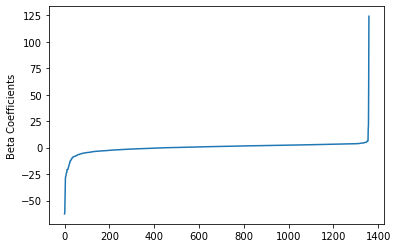

In [21]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

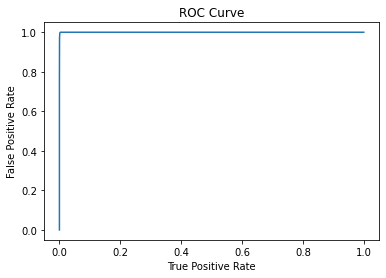

Training set areaUnderROC: 0.9999246035952065


In [22]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

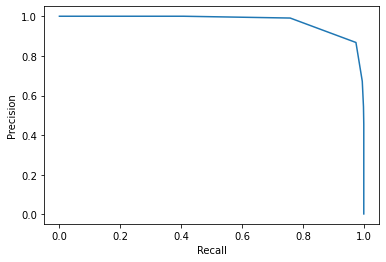

In [23]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

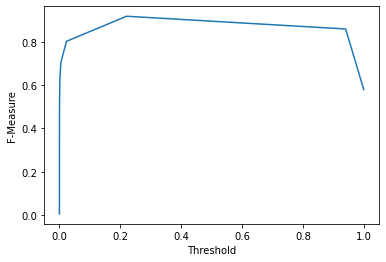

In [24]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

In [25]:
predictions = lrModel.transform(test)
predictions.select( 
 'INTERFACE_DESCR',
 'NODE_LOCATION',
 'ERRORS_-_PACKETS_IN_(SUM)',
 'DISCARDS_-_PACKETS_OUT_(SUM)',
 'BROADCAST_-_PACKETS_IN_(SUM)',
 'MULTICAST_-_PACKETS_IN_(SUM)',
 'THROUGHPUT_OUT_(BPS)_(AVG)',
 'UTILIZATION_OUT_(AVG)',
#  'AVAILABILITY_(AVG)',
#  'UTILIZATION_IN_(MAX)',
 'label', 'rawPrediction', 'prediction', 'probability').show(10000)

+--------------------+--------------------+-------------------------+----------------------------+----------------------------+----------------------------+--------------------------+---------------------+-----+--------------------+----------+--------------------+
|     INTERFACE_DESCR|       NODE_LOCATION|ERRORS_-_PACKETS_IN_(SUM)|DISCARDS_-_PACKETS_OUT_(SUM)|BROADCAST_-_PACKETS_IN_(SUM)|MULTICAST_-_PACKETS_IN_(SUM)|THROUGHPUT_OUT_(BPS)_(AVG)|UTILIZATION_OUT_(AVG)|label|       rawPrediction|prediction|         probability|
+--------------------+--------------------+-------------------------+----------------------------+----------------------------+----------------------------+--------------------------+---------------------+-----+--------------------+----------+--------------------+
|             port 28|      Kolesnikova;37|                        0|                           0|                         147|                     2542274|               525967.3125| 5.249999812804163E-4|

In [26]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))


Test Area Under ROC 0.9997774055014623


In [27]:
evaluator.getMetricName()

'areaUnderROC'

In [28]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('Test Area Under ROC', evaluator.evaluate(predictions))


Test Area Under ROC 0.999429630520899


In [29]:

predictions.coalesce(1).write.mode("overwrite").format("json").save("output.json")

In [30]:
spark.stop()